# Sample implementation using Segment.py

In [1]:
from segment import Segment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

# Create Test Dataset

In [2]:
def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def normalize(x,y):
    x_normalized = torch.nn.functional.normalize(x, dim=0)
    y_normalized = torch.nn.functional.normalize(y, dim=0)
    return x_normalized, y_normalized

In [3]:
x_in = torch.arange(-1.5, 11., .05)
ytest = f_quartic(x_in)
#normalization - important
x_in, ytest = normalize(x_in, ytest)
print(x_in.shape, ytest.shape)

# Reshape x, ytest to N,1
x_in = x_in.view(x_in.shape[0], 1)
ytest = ytest.reshape(x_in.shape[0], 1)
print(x_in.shape, ytest.shape)

torch.Size([250]) torch.Size([250])
torch.Size([250, 1]) torch.Size([250, 1])


# Model Init

In [4]:
torch.manual_seed(10)

model = Segment(x_in.shape[1], ytest.shape[1], 10)

#Initialize model parameters - extremely important.
model.custom_init(x_in.min(dim=0).values, x_in.max(dim=0).values)

criterion = nn.MSELoss(reduction='sum')

lr=.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)

# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x_in, ytest)
batch_size=64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


## Training Loop

In [5]:
num_epochs = 2000
losses = np.array([])
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        # Forward pass
        [X, Y] = data
        ypred = model(X)
        # Calculate the loss
        loss = criterion(ypred, Y)
        train_loss += loss.item()
        
        # Backward and optimize
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        #Moved following code inside segment.py
        # Cleanup if optimizer assigned overlapping params
        #with torch.no_grad():
        #    for i in np.arange(model.x.shape[1] -1):
        #        if model.x.data[:,i+1,:] < model.x.data[:,i,:]:
        #            model.x.data[:,i+1,:] = model.x.data[:,i,:]
            # The following mask is not giving the same results for segment=14
            # Create a mask for elements where the next column is less than the current column
        #    mask = model.x.data[:, 1:, :] < model.x.data[:, :-1, :]
            # Replace values in the next column where the mask is True
        #    model.x.data[:, 1:, :][mask] = model.x.data[:, :-1, :][mask]

    if epoch % (num_epochs/10) == 0:
        losses = np.append(losses, train_loss)
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss))

====> Epoch: 200 Average loss: 0.1155
====> Epoch: 400 Average loss: 0.0113
====> Epoch: 600 Average loss: 0.0038
====> Epoch: 800 Average loss: 0.0025
====> Epoch: 1000 Average loss: 0.0020
====> Epoch: 1200 Average loss: 0.0016
====> Epoch: 1400 Average loss: 0.0015
====> Epoch: 1600 Average loss: 0.0014
====> Epoch: 1800 Average loss: 0.0014
====> Epoch: 2000 Average loss: 0.0014


last total_mean_loss  0.0013945091341156512


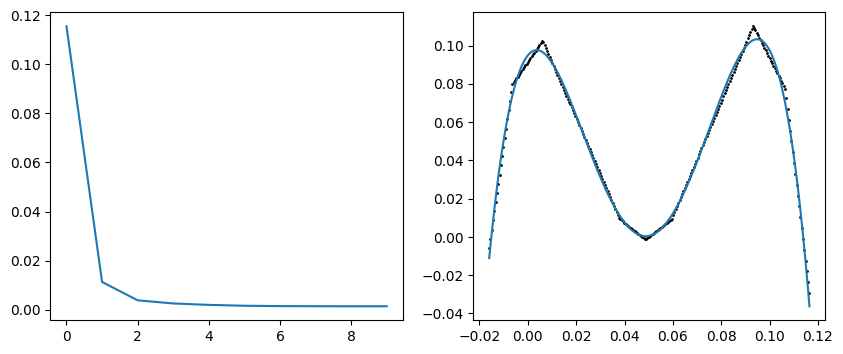

In [6]:
# plot graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (10, 4) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
print ("last total_mean_loss ",train_loss)
ax1.plot(losses)

# plot trained model
y = model(x_in)
y = y.detach().numpy()
ax2.plot(x_in, ytest)
ax2.scatter(x_in, y, color='black', s=1)

# Display the plot
plt.show()

# Plot model parameters

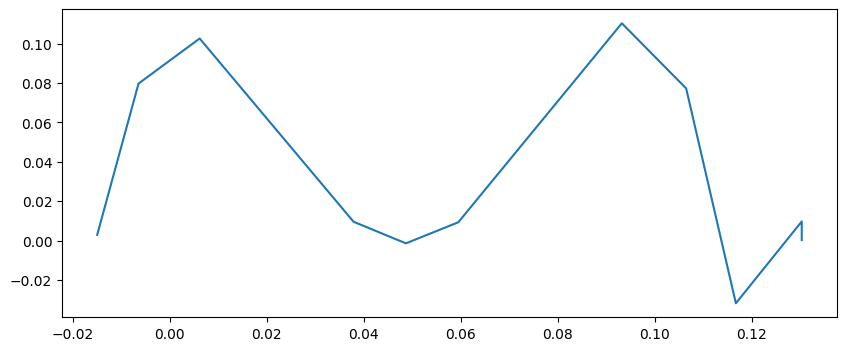

In [7]:
xval = model.x.reshape(model.x.shape[1]).detach().numpy()
yval = model.y.reshape(model.x.shape[1]).detach().numpy()
plt.plot(xval,yval) 
plt.show()

In [8]:
model.x.reshape(model.x.shape[1]),model.y.reshape(model.x.shape[1])

(tensor([-0.0150, -0.0065,  0.0061,  0.0379,  0.0487,  0.0595,  0.0932,  0.1065,
          0.1167,  0.1303,  0.1303], grad_fn=<ViewBackward0>),
 tensor([ 0.0029,  0.0798,  0.1027,  0.0096, -0.0014,  0.0093,  0.1104,  0.0773,
         -0.0318,  0.0097,  0.0003], grad_fn=<ViewBackward0>))

In [9]:
x_test = torch.Tensor([[.03],[.032]])
x_test.shape

torch.Size([2, 1])

In [10]:
model.x.data.sort_()

AttributeError: 'Tensor' object has no attribute 'sort_'

In [ ]:
param_array = model.parameters()

<generator object Module.parameters at 0x17c8f21f0>

In [ ]:
model.x

Parameter containing:
tensor([[[-0.0135],
         [-0.0113],
         [-0.0195],
         [ 0.0019],
         [ 0.0226],
         [ 0.0406],
         [ 0.0221],
         [ 0.0262],
         [ 0.0522],
         [ 0.0775],
         [ 0.0765],
         [ 0.0759],
         [ 0.0747],
         [ 0.0991],
         [ 0.1144]]], requires_grad=True)

In [ ]:
with torch.no_grad():
    model.x = nn.Parameter(model.x.sort(dim=-2).values)

model.x

Parameter containing:
tensor([[[-0.0195],
         [-0.0135],
         [-0.0113],
         [ 0.0019],
         [ 0.0221],
         [ 0.0226],
         [ 0.0262],
         [ 0.0406],
         [ 0.0522],
         [ 0.0747],
         [ 0.0759],
         [ 0.0765],
         [ 0.0775],
         [ 0.0991],
         [ 0.1144]]], requires_grad=True)